# Histology

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# origen = "lung_scc"
# destino = "pulmon_carcinoma"

# # Listar archivos en la carpeta de origen
# archivos = os.listdir(origen)

# # Iterar sobre los archivos en la carpeta de origen
# for archivo in archivos:
#     ruta_origen = os.path.join(origen, archivo)
#     ruta_destino = os.path.join(destino, archivo)
    
#     # Verificar si el archivo es una imagen (puedes agregar más extensiones si es necesario)
#     if archivo.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
#         # Verificar si es un archivo (evitar carpetas u otros elementos)
#         if os.path.isfile(ruta_origen):
#             # Leer la imagen con OpenCV
#             imagen = cv.imread(ruta_origen)
#             if imagen is not None:
#                 # Convertir la imagen a escala de grises
#                 nueva_imagen = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
#                 # Guardar la copia con el mismo nombre en la carpeta destino
#                 cv.imwrite(ruta_destino, nueva_imagen)
#                 print(f'Imagen copiada y procesada: {archivo}')
#             else:
#                 print(f'Error al leer: {archivo}')
#         else:
#             print(f'Omitido (no es un archivo): {archivo}')
#     else:
#         print(f'No es una imagen: {archivo}')

In [43]:
# Parámetros
dataset_dir = "C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\PF\\Data_set"
batch_size = 32
img_size = (224, 224)  # Ajusta el tamaño deseado
validation_split = 0.2  # 20% de los datos para validación
seed = 123  # Semilla para reproducibilidad

# Carga del dataset para entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",        # Usamos la parte de entrenamiento
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",  # O 'int' según tus necesidades
    shuffle=True
)

# Carga del dataset para validación
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",      # Usamos la parte de validación
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Verificar etiquetas asignadas
class_names = train_ds.class_names  # Debería mostrar ['cats', 'dogs']
print("Clases asignadas:", class_names)

# Verificar tamaños de los datasets
train_size = tf.data.experimental.cardinality(train_ds).numpy()
val_size = tf.data.experimental.cardinality(val_ds).numpy()

print(f"Entrenamiento: {train_size} batches")
print(f"Validación: {val_size} batches")

# Función para normalizar las imágenes
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Aplicar la normalización a los datasets
train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Clases asignadas: ['pulmon_adenocarcinoma', 'pulmon_benigno', 'pulmon_carcinoma']
Entrenamiento: 375 batches
Validación: 94 batches


In [46]:
input_shape = (224, 224, 3)
num_classes = 3

In [47]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="categorical_crossentropy")

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 61s 155ms/step - loss: 0.1975 - accuracy: 0.9212 - val_loss: 2.2049 - val_accuracy: 0.5390
Epoch 2/50
375/375 [==============================] - 58s 154ms/step - loss: 0.0429 - accuracy: 0.9853 - val_loss: 2.3361 - val_accuracy: 0.6617
Epoch 3/50
375/375 [==============================] - 58s 155ms/step - loss: 0.0236 - accuracy: 0.9923 - val_loss: 0.6667 - val_accuracy: 0.8667
Epoch 4/50
375/375 [==============================] - 57s 152ms/step - loss: 0.0249 - accuracy: 0.9924 - val_loss: 1.5951 - val_accuracy: 0.7883
Epoch 5/50
375/375 [==============================] - 57s 152ms/step - loss: 0.0173 - accuracy: 0.9951 - val_loss: 1.7172 - val_accuracy: 0.7023
Epoch 6/50
375/375 [==============================] - 58s 153ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.7123 - val_accuracy: 0.8803
Epoch 7/50
375/375 [==============================] - 58s 153ms/step - loss: 0.0130 - accuracy: 0.9963 - val_loss: 0.6032 - val_ac

In [ ]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

94/94 [==============================] - 4s 45ms/step - loss: 0.0018 - accuracy: 0.9993
Accuracy: 0.9993333220481873


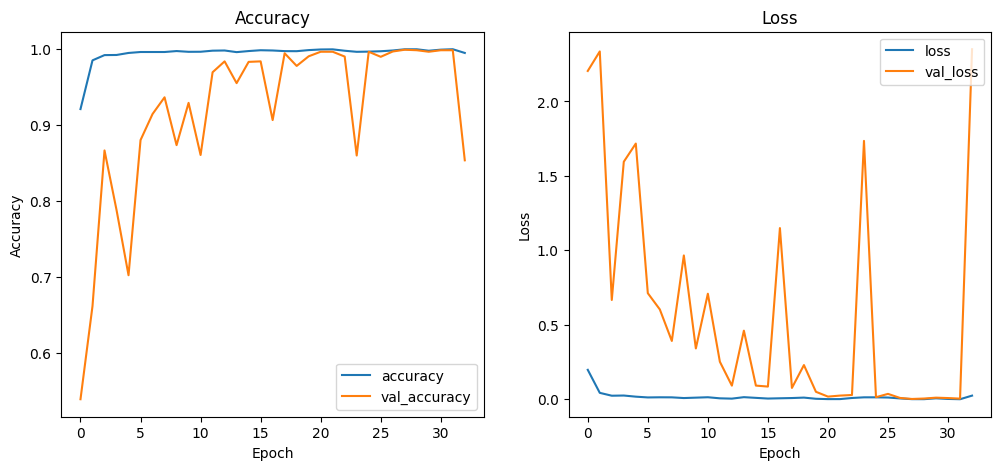

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [ ]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predy_test_clases = np.argmax(y_true, axis=1)icciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_test_clases = np.argmax(y_true, axis=1)
y_pred = np.concatenate(y_pred_list)

1/1 [==============================] - 0s 23ms/step


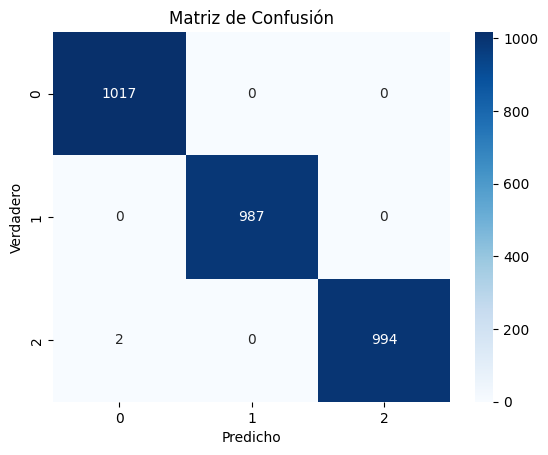

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_clases, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [59]:
# Cargar la imagen
img_path = "C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\PF\\Imagenes prueba\\car2.jpg"  # Ruta de la imagen
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (224, 224))
img = np.expand_dims(img, axis=-1)
img = np.concatenate([img, img, img], axis=-1)

# Convertir la imagen a un array de numpy
img_array = image.img_to_array(img)

# Normalizar la imagen (MobileNetV2 usa valores entre 0 y 1)
img_array = img_array / 255.0

# Expandir dimensiones para que tenga forma (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Realizar la predicción
y_pred_probs = model.predict(img_array)  # Salida con probabilidades para cada clase

# Obtener la clase con mayor probabilidad
y_pred_label = np.argmax(y_pred_probs, axis=1)[0]  # 0 = adenocarcinoma, 1 = benigno, 2 = carcinoma

# Diccionario para mapear índices a nombres de clases
class_names = ["pulmon_adenocarcinoma", "pulmon_benigno", "pulmon_carcinoma"]

# Mostrar la clase predicha
print(f"Clase predicha: {class_names[y_pred_label]}")

1/1 [==============================] - 0s 25ms/step
Clase predicha: pulmon_carcinoma


In [60]:
model.save("C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\PF\\Modelos\\modelo_MobileNetV2_probable_sobreajuste.h5")

In [61]:
del model  # Elimina el modelo de la memoria RAM
tf.keras.backend.clear_session()  # Libera recursos de TensorFlow